In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    # Install xvfb and our launcher script for it
    !apt-get install -y xvfb
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/xvfb -O ../xvfb

    # Download dependencies from Github
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/atari_wrappers.py
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/env_batch.py
    !wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/runners.py

    # Update the gym environment to be compatible with the Atari environment
    !pip install -q gymnasium[atari,accept-rom-license]
    !pip install -q tensorboardX

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

??? ????????????? ????????????? ?????????? Windows ??? Linux.

???????????? ????? ?????????? ?? Microsoft Store:

https://aka.ms/wslstore



In [2]:
!pip install -q gym[accept-rom-license] --quiet
# !pip install -q ale-py==0.8.1
!pip install -q gymnasium==0.29.1
!pip install -q shimmy==1.*

In [3]:
!pip install -q autorom[accept-rom-license]
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	C:\RL\Practical_RL\.venv\Lib\site-packages\AutoROM\roms

Existing ROMs will be overwritten.
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\adventure.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\air_raid.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\alien.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\amidar.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\assault.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\asterix.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\asteroids.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\atlantis.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\atlantis2.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packages\AutoROM\roms\backgammon.bin
Installed C:\RL\Practical_RL\.venv\lib\site-packa

# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel.

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscale, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here.



In [4]:
import numpy as np
import gymnasium as gym
from atari_wrappers import nature_dqn_env


env_name = "SpaceInvadersNoFrameskip-v4"
nenvs = 16  # change this if you have more than 8 CPU ;)
summaries = "Tensorboard"

env = nature_dqn_env(env_name, nenvs=nenvs, summaries=summaries)
obs, _ = env.reset()
assert obs.shape == (nenvs, 4, 84, 84)
assert obs.dtype == np.float32


Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://www.nature.com/articles/nature14236) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros.

In [5]:
import tensorflow as torch
import torch as tf
import torch.nn as nn
import torch.nn.functional as F

class A2CModel(nn.Module):
    def __init__(self, num_actions):
        super(A2CModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(7 * 7 * 64, 512)
        self.policy = nn.Linear(512, num_actions)
        self.value = nn.Linear(512, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=2**0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Сглаживание
        x = F.relu(self.fc(x))
        logits = self.policy(x)
        values = self.value(x)
        return logits, values

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework.

In [6]:
import torch.distributions as distributions

class Policy:
    def __init__(self, model):
        self.model = model
        self.device = next(self.model.parameters()).device

    def act(self, inputs):
        inputs_t = torch.from_numpy(inputs).to(self.device)
        logits, values = self.model(inputs_t)
        dist = distributions.Categorical(logits=logits)
        actions_t = dist.sample()
        log_probs = dist.log_prob(actions_t)
        actions_np = actions_t.cpu().numpy()
        values = values.squeeze(-1)

        return {
            'actions': actions_np,      # np.ndarray (nenvs,)
            'logits': logits,           # torch.Tensor (nenvs, num_actions)
            'log_probs': log_probs,     # torch.Tensor (nenvs,)
            'values': values            # torch.Tensor (nenvs,)
        }


Next will pass the environment and policy to a runner that collects partial trajectories from the environment.
The class that does is is already implemented for you.

In [7]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys

* 'observations'
* 'rewards'
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment. This list has length $T$ that is size of partial trajectory. Partial trajectory for given moment `t` is part of `ComputeValueTargets.__call__` input argument `trajectory` from moment `t` to the end (i.e. it's different at each iteration in the algorithm).

To train the part of the model that predicts state values you will need to compute the value targets.
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected.
Thus, we can implement and use `ComputeValueTargets` callable.
The formula for the value targets is simple:

$$
\hat v(s_t) = \left( \sum_{t'=0}^{T - 1} \gamma^{t'}r_{t+t'} \right) + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use
`trajectory['resets']` flags to check if you need to add the value targets at the next step when
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [8]:
class ComputeValueTargets:
    def __init__(self, policy, gamma=0.99):
        self.policy = policy
        self.gamma = gamma

    def __call__(self, trajectory):
        T = len(trajectory['rewards'])
        latest_obs = trajectory['state']['latest_observation']
        policy_output = self.policy.act(latest_obs)
        v_next = policy_output['values'].detach()  # (nenvs,)

        value_targets = []
        for t in range(T - 1, -1, -1):
            rewards_t = trajectory['rewards'][t]  # numpy (nenvs,)
            resets_t = trajectory['resets'][t]    # numpy (nenvs,) bool
            rewards_t = torch.from_numpy(rewards_t).to(v_next.device).float()
            resets_t = torch.from_numpy(resets_t).to(v_next.device)
            v_target_t = rewards_t + self.gamma * v_next * (~resets_t).float()
            value_targets.insert(0, v_target_t)
            v_next = v_target_t

        trajectory['value_targets'] = value_targets

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `env_steps * num_envs`, i.e. you essentially need
to flatten the first two dimensions.

In [9]:
class MergeTimeBatch:
    """Merges first two axes typically representing time and env batch."""
    def __call__(self, trajectory):
        if 'value_targets' in trajectory and len(trajectory['value_targets']) > 0:
            device = trajectory['value_targets'][0].device
        else:
            device = torch.device('cpu')

        for key in list(trajectory.keys()):
            if isinstance(trajectory[key], list) and len(trajectory[key]) > 0:
                first_elem = trajectory[key][0]
                if isinstance(first_elem, np.ndarray):
                    stacked = np.stack(trajectory[key], axis=0)
                    tensor = torch.from_numpy(stacked).to(device)
                elif isinstance(first_elem, torch.Tensor):
                    tensor = torch.stack(trajectory[key], dim=0)
                else:
                    continue

                T, nenvs = tensor.shape[0], tensor.shape[1]
                batch_size = T * nenvs
                if len(tensor.shape) > 2:
                    new_shape = (batch_size,) + tensor.shape[2:]
                else:
                    new_shape = (batch_size,)
                flattened = tensor.view(*new_shape)

                trajectory[key] = flattened

        return trajectory


In [10]:
model = A2CModel(num_actions=6)
policy = Policy(model)
runner = EnvRunner(
    env=env,
    policy=policy,
    nsteps=5,
    transforms=[
        ComputeValueTargets(policy),
        MergeTimeBatch(),
    ],
)


Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [11]:
class A2C:
    def __init__(self,
                 policy,
                 optimizer,
                 value_loss_coef=0.25,
                 entropy_coef=0.01,
                 max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm

    def policy_loss(self, trajectory):
        log_probs = trajectory['log_probs']  # (batch_size,)
        values = trajectory['values']  # (batch_size,)
        value_targets = trajectory['value_targets']  # (batch_size,)
        advantages = (value_targets - values).detach()
        policy_loss = -(log_probs * advantages).mean()
        return policy_loss

    def value_loss(self, trajectory):
        values = trajectory['values']  # (batch_size,)
        value_targets = trajectory['value_targets']  # (batch_size,)
        value_loss = 0.5 * ((values - value_targets) ** 2).mean()
        return value_loss

    def loss(self, trajectory):
        policy_loss = self.policy_loss(trajectory)
        value_loss = self.value_loss(trajectory)
        logits = trajectory['logits']  # (batch_size, num_actions)
        dist = distributions.Categorical(logits=logits)
        entropy = dist.entropy().mean()
        total_loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * entropy
        return total_loss

    def step(self, trajectory):
        self.optimizer.zero_grad()
        loss = self.loss(trajectory)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()


Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to
`runner.step_var` &mdash; the number of interactions with all environments. It is highly
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.

In [12]:
from torch.optim.lr_scheduler import LambdaLR
import torch.distributions as distributions
import torch
from tqdm import tqdm

total_iterations = 25000

optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-4, alpha=0.99, eps=1e-5)
scheduler = LambdaLR(optimizer, lr_lambda=lambda i: max(0.0, 1 - i / total_iterations))
a2c = A2C(policy=policy, optimizer=optimizer)

step_vars = []

for i in tqdm(range(total_iterations), desc="Training A2C"):
    trajectory = runner.get_next()

    with torch.no_grad():
        values = trajectory['values']
        value_targets = trajectory['value_targets']
        advantages = value_targets - values
        r2 = 1 - torch.sum((value_targets - values)**2) / torch.sum((value_targets - value_targets.mean())**2)
        entropy = distributions.Categorical(logits=trajectory['logits']).entropy().mean()
        policy_loss_val = a2c.policy_loss(trajectory)
        value_loss_val = a2c.value_loss(trajectory)
        total_loss_val = a2c.loss(trajectory)

        step_vars.append(runner.step_var)

        env.writer.add_scalar('metrics/r2', r2.item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/entropy', entropy.item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/policy_loss', policy_loss_val.item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/value_loss', value_loss_val.item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/total_loss', total_loss_val.item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/advantages_mean', advantages.mean().item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/value_targets_mean', value_targets.mean().item(), global_step=runner.step_var)
        env.writer.add_scalar('metrics/values_mean', values.mean().item(), global_step=runner.step_var)

        if i % 1000 == 0:
            print(f"\nIteration {i}, Step {runner.step_var}:")
            print(f"  R²: {r2.item():.4f}")
            print(f"  Entropy: {entropy.item():.4f}")
            print(f"  Policy Loss: {policy_loss_val.item():.4f}")
            print(f"  Value Loss: {value_loss_val.item():.4f}")
            print(f"  Total Loss: {total_loss_val.item():.4f}")
            print(f"  Advantages Mean: {advantages.mean().item():.4f}")
            print(f"  Value Targets Mean: {value_targets.mean().item():.4f}")
            print(f"  Values Mean: {values.mean().item():.4f}")

    a2c.step(trajectory)
    scheduler.step()

Training A2C:  44%|████▍     | 11002/25000 [15:26<19:44, 11.82it/s]


Iteration 11000, Step 880080:
  R²: 0.9711
  Entropy: 1.4644
  Policy Loss: -0.0034
  Value Loss: 0.0090
  Total Loss: -0.0158
  Advantages Mean: 0.0022
  Value Targets Mean: 1.5483
  Values Mean: 1.5461


Training A2C:  48%|████▊     | 12002/25000 [16:52<18:35, 11.66it/s]


Iteration 12000, Step 960080:
  R²: 0.9908
  Entropy: 1.4971
  Policy Loss: -0.0154
  Value Loss: 0.0031
  Total Loss: -0.0296
  Advantages Mean: -0.0074
  Value Targets Mean: 1.5110
  Values Mean: 1.5185


Training A2C:  52%|█████▏    | 13002/25000 [18:17<16:48, 11.90it/s]


Iteration 13000, Step 1040080:
  R²: 0.9916
  Entropy: 1.6937
  Policy Loss: -0.0216
  Value Loss: 0.0030
  Total Loss: -0.0378
  Advantages Mean: -0.0142
  Value Targets Mean: 1.0633
  Values Mean: 1.0775


Training A2C:  56%|█████▌    | 14002/25000 [19:41<15:26, 11.87it/s]


Iteration 14000, Step 1120080:
  R²: 0.8414
  Entropy: 1.6224
  Policy Loss: 0.1293
  Value Loss: 0.0486
  Total Loss: 0.1253
  Advantages Mean: 0.0742
  Value Targets Mean: 1.7361
  Values Mean: 1.6619


Training A2C:  60%|██████    | 15002/25000 [21:07<13:57, 11.94it/s]


Iteration 15000, Step 1200080:
  R²: 0.8297
  Entropy: 1.6507
  Policy Loss: 0.0497
  Value Loss: 0.0242
  Total Loss: 0.0392
  Advantages Mean: 0.0479
  Value Targets Mean: 1.4066
  Values Mean: 1.3586


Training A2C:  64%|██████▍   | 16002/25000 [22:31<12:31, 11.97it/s]


Iteration 16000, Step 1280080:
  R²: 0.9132
  Entropy: 1.6168
  Policy Loss: -0.0295
  Value Loss: 0.0348
  Total Loss: -0.0370
  Advantages Mean: -0.0242
  Value Targets Mean: 1.4994
  Values Mean: 1.5236


Training A2C:  68%|██████▊   | 17002/25000 [23:56<10:54, 12.23it/s]


Iteration 17000, Step 1360080:
  R²: 0.9545
  Entropy: 1.6155
  Policy Loss: 0.0704
  Value Loss: 0.0309
  Total Loss: 0.0620
  Advantages Mean: 0.0465
  Value Targets Mean: 2.1579
  Values Mean: 2.1113


Training A2C:  72%|███████▏  | 18001/25000 [25:20<10:03, 11.60it/s]


Iteration 18000, Step 1440080:
  R²: 0.9098
  Entropy: 1.5843
  Policy Loss: 0.0580
  Value Loss: 0.0376
  Total Loss: 0.0515
  Advantages Mean: 0.0517
  Value Targets Mean: 1.8957
  Values Mean: 1.8440


Training A2C:  76%|███████▌  | 19001/25000 [26:45<08:38, 11.56it/s]


Iteration 19000, Step 1520080:
  R²: 0.9075
  Entropy: 1.7029
  Policy Loss: -0.1380
  Value Loss: 0.0225
  Total Loss: -0.1494
  Advantages Mean: -0.0775
  Value Targets Mean: 1.2613
  Values Mean: 1.3388


Training A2C:  80%|████████  | 20001/25000 [28:09<07:04, 11.76it/s]


Iteration 20000, Step 1600080:
  R²: 0.7998
  Entropy: 1.5737
  Policy Loss: 0.0851
  Value Loss: 0.0837
  Total Loss: 0.0903
  Advantages Mean: 0.0286
  Value Targets Mean: 1.8879
  Values Mean: 1.8594


Training A2C:  84%|████████▍ | 21001/25000 [29:34<05:42, 11.67it/s]


Iteration 21000, Step 1680080:
  R²: 0.8985
  Entropy: 1.6018
  Policy Loss: -0.0766
  Value Loss: 0.0260
  Total Loss: -0.0861
  Advantages Mean: -0.0467
  Value Targets Mean: 1.6162
  Values Mean: 1.6630


Training A2C:  88%|████████▊ | 22003/25000 [30:58<04:12, 11.89it/s]


Iteration 22000, Step 1760080:
  R²: 0.8920
  Entropy: 1.5092
  Policy Loss: -0.0860
  Value Loss: 0.0311
  Total Loss: -0.0933
  Advantages Mean: -0.0542
  Value Targets Mean: 1.9681
  Values Mean: 2.0223


Training A2C:  92%|█████████▏| 23001/25000 [32:22<02:50, 11.76it/s]


Iteration 23000, Step 1840080:
  R²: 0.8479
  Entropy: 1.5392
  Policy Loss: 0.0576
  Value Loss: 0.0698
  Total Loss: 0.0597
  Advantages Mean: 0.0640
  Value Targets Mean: 2.4035
  Values Mean: 2.3395


Training A2C:  96%|█████████▌| 24001/25000 [33:46<01:22, 12.11it/s]


Iteration 24000, Step 1920080:
  R²: 0.8841
  Entropy: 1.4346
  Policy Loss: 0.0525
  Value Loss: 0.0825
  Total Loss: 0.0588
  Advantages Mean: 0.0747
  Value Targets Mean: 2.7272
  Values Mean: 2.6525


Training A2C: 100%|██████████| 25000/25000 [35:10<00:00, 11.84it/s]


In [19]:
%reload_ext tensorboard

In [ ]:
#if you use TensorboardSummaries
%load_ext tensorboard
%tensorboard --logdir logs
%reload_ext tensorboard

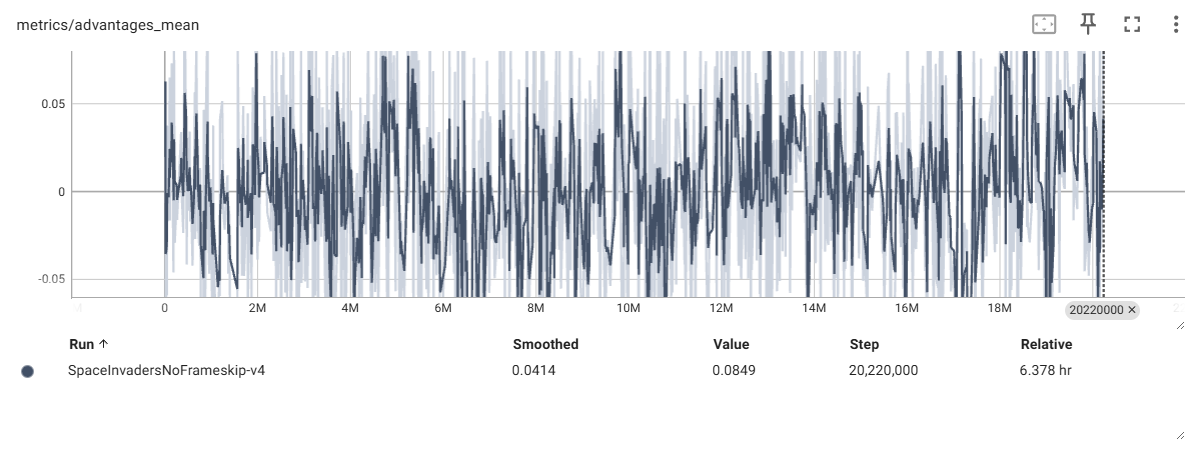

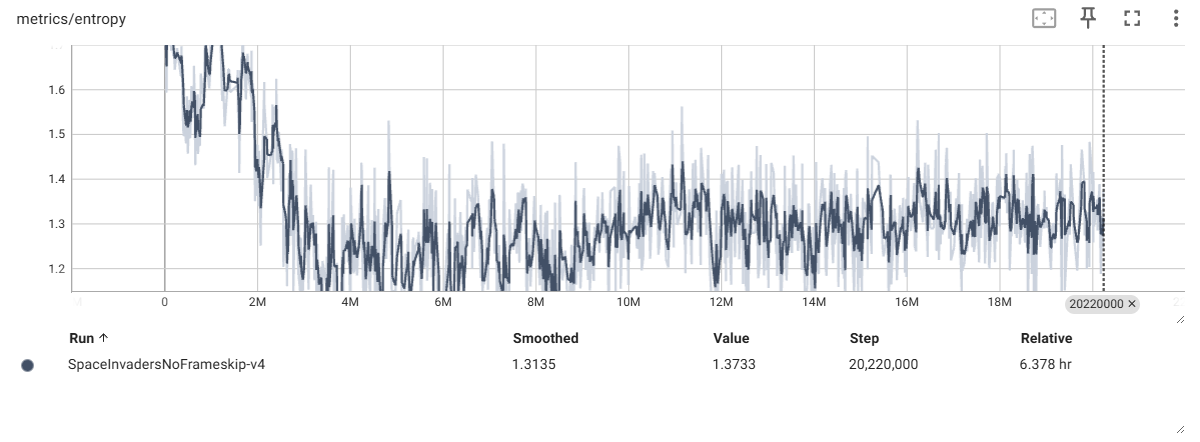

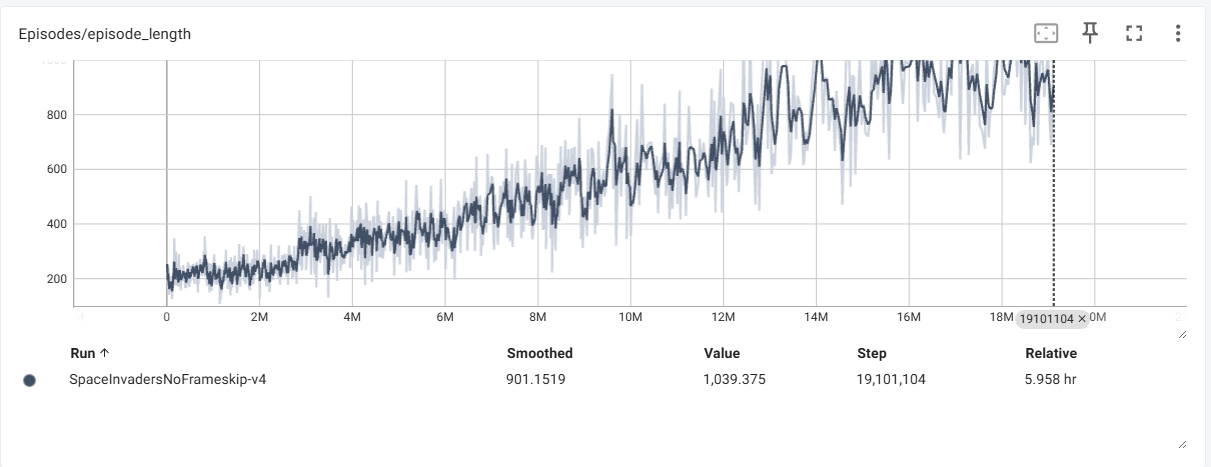

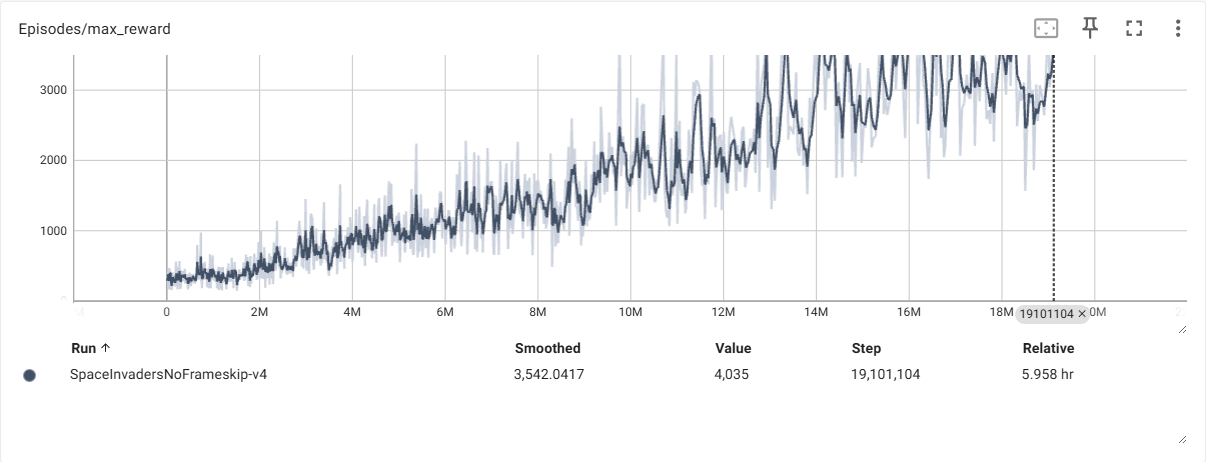

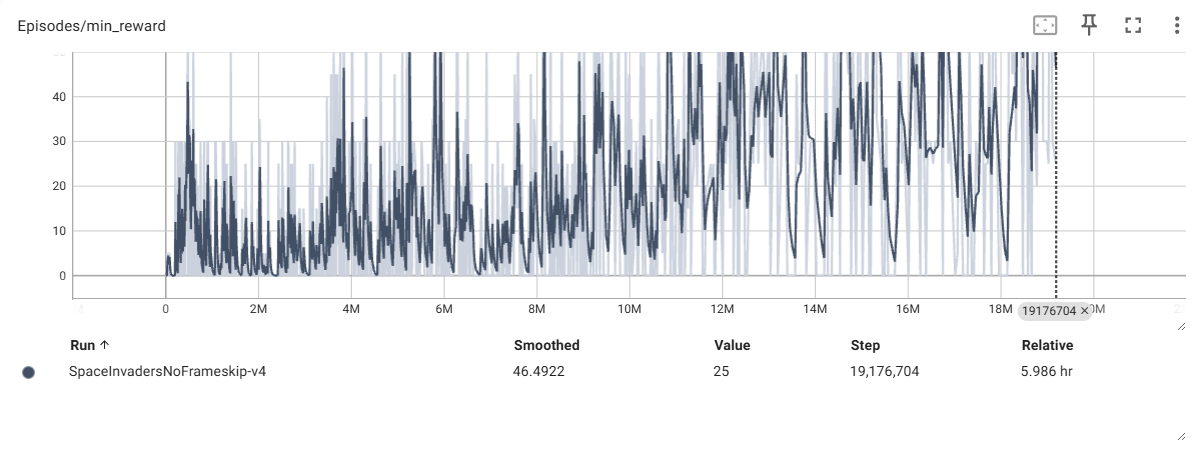

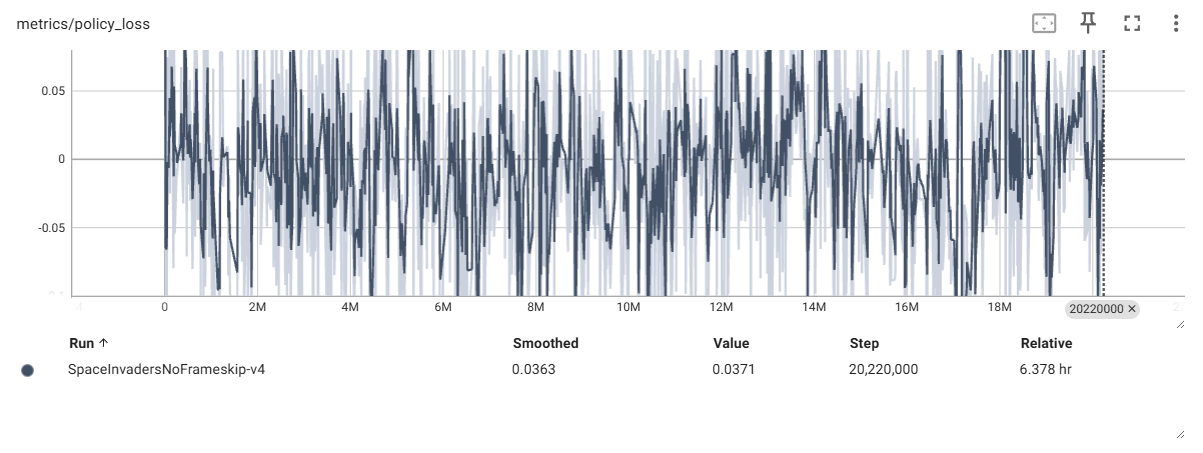

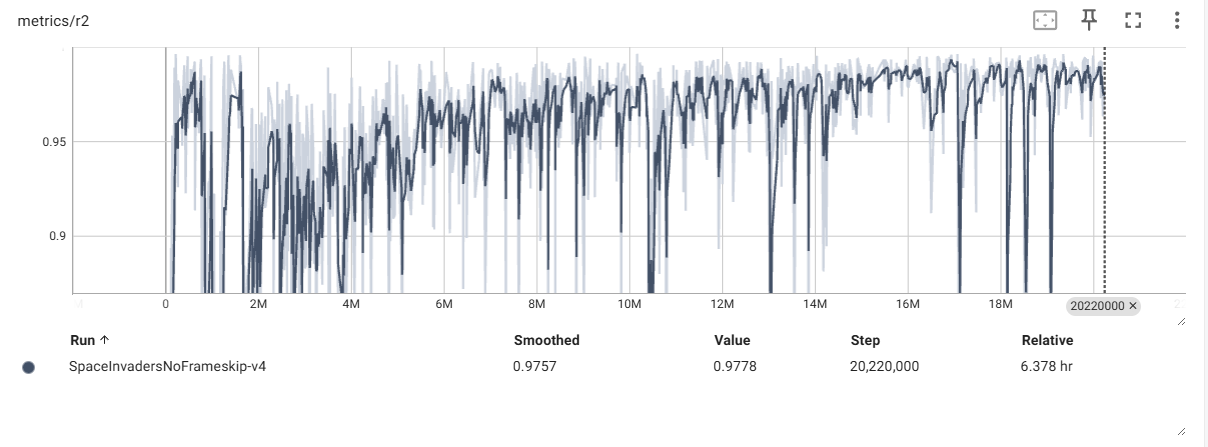

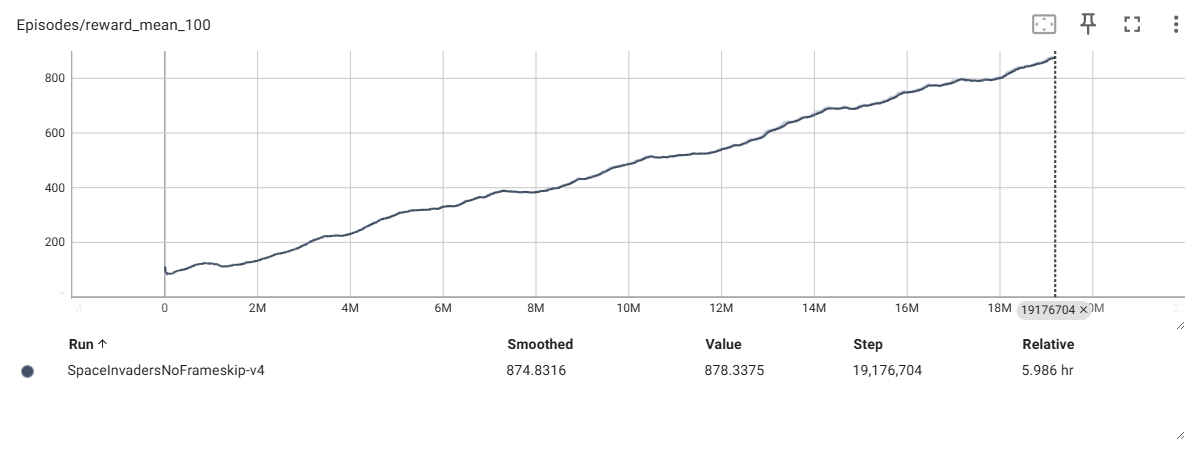

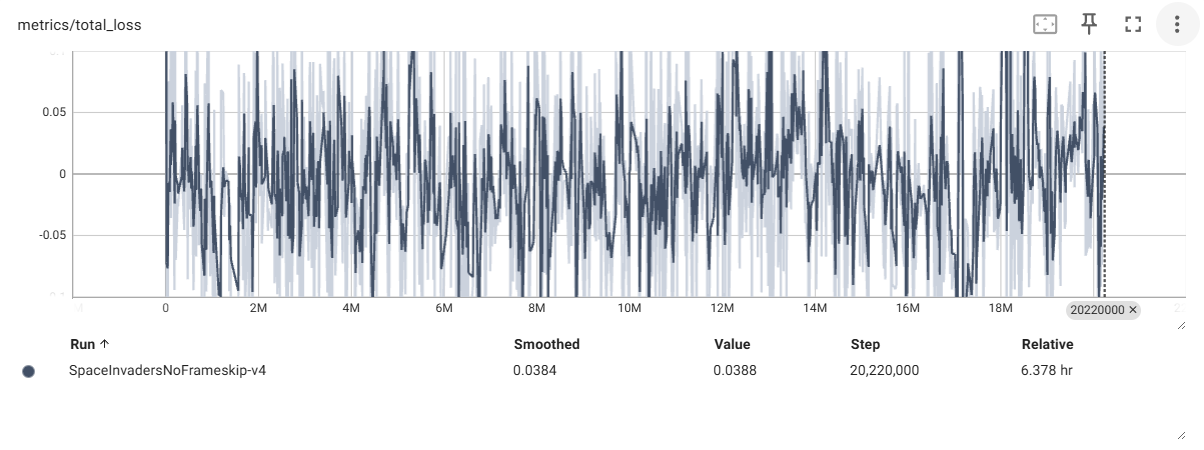

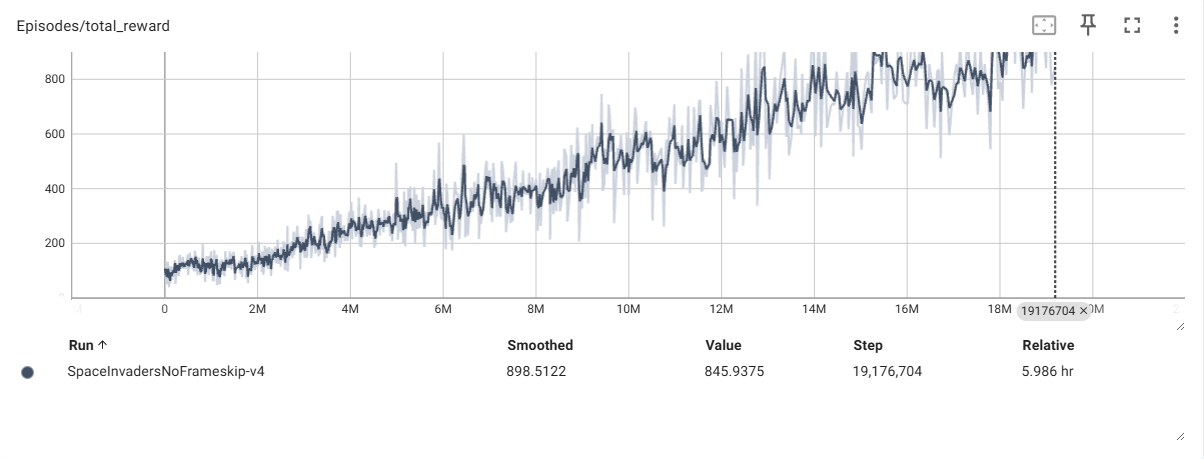

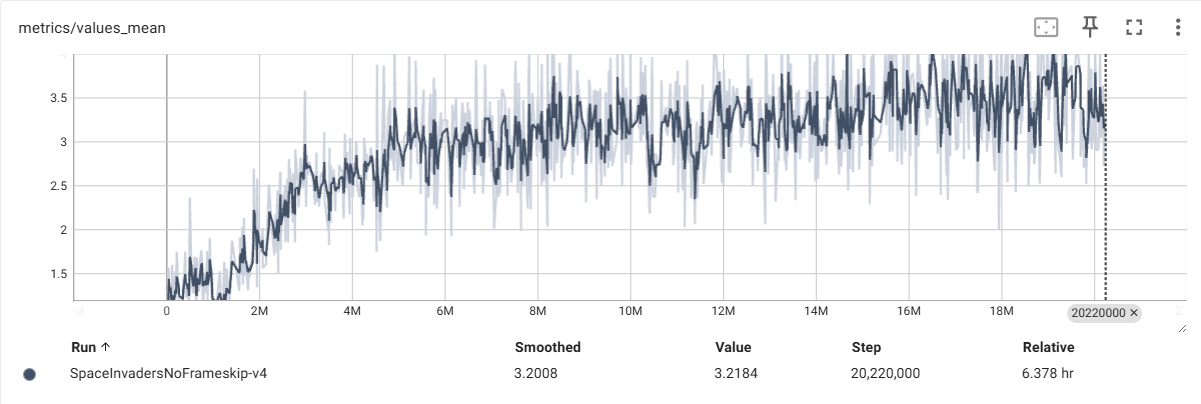

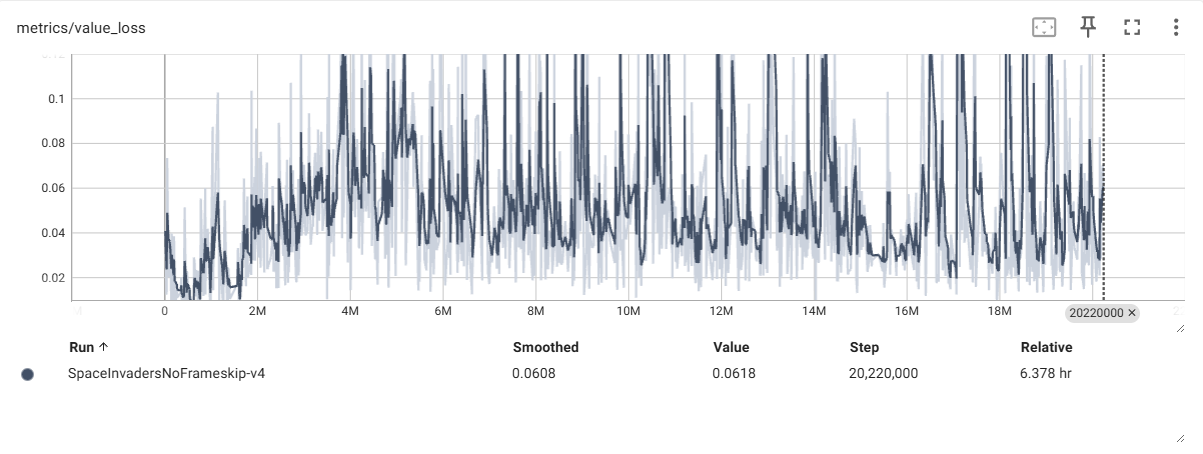

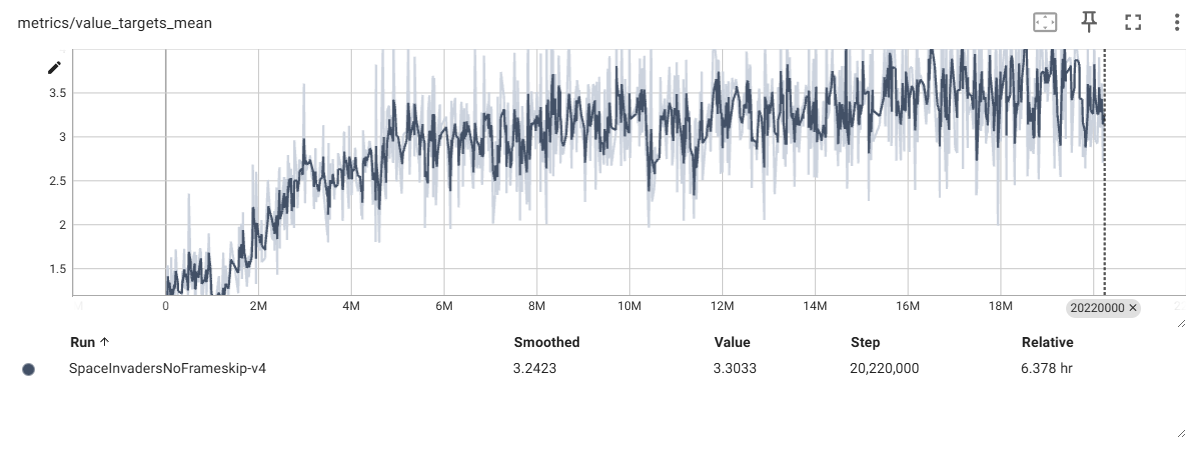

In [16]:
from IPython.display import Image, display
import os

image_dir = "pics"

image_paths = [
    os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png'))
]

for path in image_paths:
    display(Image(filename=path))

In [ ]:
Загружены сохраненные результаты самого долгого запуска

### Target networks?

You may recall a technique called "target networks" we used a few weeks ago when we trained a DQN agent to play Atari Breakout and wonder why we have not suggested using them here. The answer is that this is more historical than practical.

While the "chasing the target" problem is still present in actor-critic value estimation and target networks do show up in follow-up papers, the original A3C/A2C papers do not mention them and do not explain this omission.

The hypothesis why this may not be a big deal (compared to Q-learning) goes like this. An A3C/A2C agent selects actions based on policy, not an epsilon greedy exploration function, for which the argmax can change drastically due to tiny errors in function approximation. Therefore, errors in the value target caused by target chasing will cause less damage.

Also, the actor-critic gradient relies on the advantage function $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$. Compare this to the $Q$-function $Q(s_t, a_t) = r(s_t, a_t) + \gamma \cdot \mathbb{E}_{s_{t+1} \mid s_t, a_t} V(s_{t+1})$ used in Q-learning and SARSA: we would expect that any bias in $V$-function approximation will be carried over from $V(s_{t+1})$ to $V(s_t)$ by gradient updates. However, in the formula for the advantage function the two approximations ($Q$-function and $V$-function) come with opposite signs, and thus the errors will cancel out.

The last reason may be computational. Authors were concerned to beat existent algorithms in the wall-clock learning time, and any overhead of parameter copying (target network update) counted against this goal.